Interpolacion Viento

## Parte 0. Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 = pd.read_csv('/content/gdrive/MyDrive/SIMA/FINAL/df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024.csv')
df_UBI = pd.read_csv('/content/gdrive/MyDrive/SIMA/BASES_DE_DATOS/PROCESADO/UBICACIONES/UBI.csv')

In [ ]:
#!pip install Basemap
!pip install geopandas
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.5 MB/s eta 0:00:00


In [ ]:
# Verificar los valores únicos en la columna 'time'
#valores_unicos_time = df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024['time'].unique()

# Imprimir los valores únicos
#print("Valores únicos en la columna 'time':")
#print(valores_unicos_time)


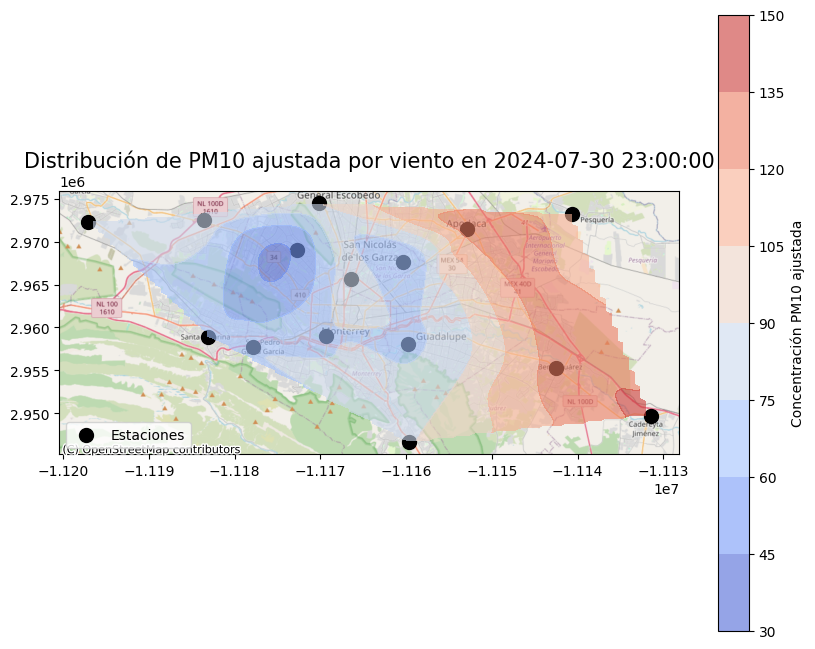

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from pyproj import Transformer

# Asegúrate de que las columnas 'date' y 'time' estén en el formato adecuado
#df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 ['date'] = pd.to_datetime(df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 ['date']).dt.date  # Solo la fecha
#df_completo['time'] = pd.to_datetime(df_completo['time']).dt.time  # Solo la hora

# Fecha y hora específicas para filtrar
fecha_especifica = '2024-07-30'
hora_especifica = '23:00:00'

# Filtrar los datos por fecha y hora separadas
df_filtrado = df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 [(df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 ['date'].astype(str) == fecha_especifica) & (df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 ['time'].astype(str) == hora_especifica)]

# Agrupar por Zona para calcular las concentraciones promedio de CO, WSR, WDR para esa fecha/hora
coords_zonas = df_filtrado.groupby('zona_encoded').agg({
    'latitud': 'mean',
    'longitud': 'mean',
    'PM10': 'mean',
    'WSR': 'mean',
    'WDR': 'mean'
}).reset_index()

# Crear un GeoDataFrame con las coordenadas de las zonas
gdf_zonas = gpd.GeoDataFrame(
    coords_zonas,
    geometry=gpd.points_from_xy(coords_zonas['longitud'], coords_zonas['latitud']),
    crs="EPSG:4326"  # Sistema de coordenadas WGS 84
)

# Transformar a un sistema de coordenadas proyectadas adecuado para añadir el mapa base
gdf_zonas = gdf_zonas.to_crs(epsg=3857)  # Proyección Web Mercator (compatible con contextily)

# Crear una malla de puntos para la interpolación
lon_grid, lat_grid = np.mgrid[
    coords_zonas['longitud'].min():coords_zonas['longitud'].max():100j,
    coords_zonas['latitud'].min():coords_zonas['latitud'].max():100j
]

# Realizar la interpolación
interpolated_CO = griddata(
    (coords_zonas['longitud'], coords_zonas['latitud']),
    coords_zonas['PM10'],
    (lon_grid, lat_grid),
    method='cubic'
)

# Ajustar la interpolación de CO según la velocidad del viento
interpolated_CO_adjusted = interpolated_CO * (1 + coords_zonas['WSR'].mean() / max(coords_zonas['WSR']))

# Crear un transformador para convertir de WGS84 (EPSG:4326) a Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

# Transformar las coordenadas de la malla
lon_grid_proj, lat_grid_proj = transformer.transform(lon_grid, lat_grid)

# Crear el mapa base
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar las estaciones
gdf_zonas.plot(ax=ax, color='black', markersize=100, label='Estaciones')

# Añadir el mapa base de contexto con contextily
ctx.add_basemap(ax, crs=gdf_zonas.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Graficar el mapa de calor utilizando las coordenadas proyectadas
contour = ax.contourf(lon_grid_proj, lat_grid_proj, interpolated_CO_adjusted, cmap='coolwarm', alpha=0.6)

# Agregar una barra de colores
cbar = fig.colorbar(contour, ax=ax, label='Concentración PM10 ajustada')

# Añadir título y etiquetas
plt.title(f'Distribución de PM10 ajustada por viento en {fecha_especifica} {hora_especifica}', fontsize=15)
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RH,SO2,SR,TOUT,WSR,WDR,time,zona_encoded,latitud,longitud
0,2022-01-01,2.600000,3.500000,44.635472,48.500000,15.000000,134.000000,46.000132,705.5,46.0,5.300000,0.000,21.37,3.400000,267.000000,00:00:00,0,25.676020,-100.335847
1,2022-01-01,2.230000,2.900000,32.900000,36.000000,19.000000,90.487099,32.866904,705.2,48.0,6.100000,0.000,20.83,3.300000,259.000000,01:00:00,0,25.676020,-100.335847
2,2022-01-01,1.990000,2.900000,27.600000,30.700000,21.000000,117.000000,35.302492,705.1,46.0,5.800000,0.000,20.52,5.900000,233.000000,02:00:00,0,25.676020,-100.335847
3,2022-01-01,2.030000,10.988332,26.355984,37.435607,18.000000,108.000000,33.597876,704.8,46.0,6.000000,0.000,20.12,5.100000,220.000000,03:00:00,0,25.676020,-100.335847
4,2022-01-01,1.860000,10.671060,25.491311,36.196048,20.000000,106.000000,31.740669,704.8,46.0,5.600000,0.000,19.85,4.700000,244.000000,04:00:00,0,25.676020,-100.335847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413850,2024-07-31,1.180000,4.200000,11.100000,15.200000,16.000000,117.000000,13.730000,707.5,46.0,2.800000,0.003,29.87,13.100000,63.000000,19:00:00,6,25.785307,-100.463958
413851,2024-07-31,1.330000,4.400000,12.500000,16.800000,13.000000,90.000000,13.050000,707.9,48.0,2.700000,0.000,28.93,11.800000,41.000000,20:00:00,6,25.785307,-100.463958
413852,2024-07-31,1.470000,4.600000,12.100000,16.600000,12.000000,90.000000,12.720000,708.4,50.0,3.000000,0.000,28.31,11.600000,41.000000,21:00:00,6,25.785307,-100.463958
413853,2024-07-31,1.260000,4.800000,11.300000,16.000000,12.000000,104.000000,13.630000,709.1,58.0,3.000000,0.000,27.25,15.300000,35.000000,22:00:00,6,25.785307,-100.463958
